In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pinocchio as pin

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF

from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.description.builder import jps_graph2pinocchio_robot, jps_graph2pinocchio_robot_3d_constraints
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import ManipulabilityReward, ZRRReward
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT, URDFLinkCreater3DConstraints
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L, get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
from auto_robot_design.optimization.saver import ProblemSaver


In [2]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(
        URDFLinkCreater3DConstraints,
        density={"default": density, "G": body_density},
        thickness={"default": thickness, "EE": 0.003},
        actuator={"default": actuator},
        size_ground=np.array(MIT_CHEETAH_PARAMS_DICT["size_ground"]),
        offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"],
    )

In [3]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_workspace_trajectory([-0.15, -0.35], 0.14, 0.3, 30, 60)))
# ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.1, -0.31], step_height=0.05, step_width=0.2, n_points=50))

ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14, -0.34], step_height=0.12, step_width=0.28, n_points=100)))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14 + 0.015, -0.34], step_height=0.10, step_width=-2*(-0.14 + 0.015), n_points=100)))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14 + 0.025 , -0.34], step_height=0.08, step_width=-2*(-0.14 + 0.025), n_points=100)))

central_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, 0, 100)))

left_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, -0.12, 100)))

right_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, 0.12, 100)))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
manipulability = ManipulabilityReward(manipulability_key='MANIP', trajectory_key="traj_6d", error_key="error")

zrr = ZRRReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
                                                                                   ground_symmetric_step2,
                                                                                   ground_symmetric_step3,
                                                                                   central_vertical,
                                                                                   left_vertical,
                                                                                   right_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(manipulability, 0, 1)
reward_manager.add_reward(manipulability, 1, 1)
reward_manager.add_reward(manipulability, 2, 1)
reward_manager.add_reward(manipulability, 3, 1)
reward_manager.add_reward(manipulability, 4, 1)
reward_manager.add_reward(manipulability, 5, 1)

reward_manager.add_reward(zrr, 0, 1)
reward_manager.add_reward(zrr, 1, 1)
reward_manager.add_reward(zrr, 2, 1)
reward_manager.add_reward(zrr, 3, 1)
reward_manager.add_reward(zrr, 4, 1)
reward_manager.add_reward(zrr, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2,3,4,5], 'mean')
#reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

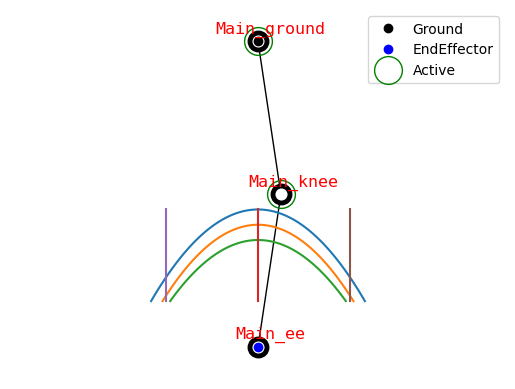

In [4]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[50:, 0], trajectory[50:, 2])
gm = get_preset_by_index_with_bounds(-1)
values = gm.generate_central_from_mutation_range()
graph = gm.get_graph(values)
draw_joint_point(graph)
plt.savefig("trajectories.png")

In [5]:
from auto_robot_design.generator.user_generator.graph_generator import TopologyManager2D
from auto_robot_design.description.kinematics import JointPoint

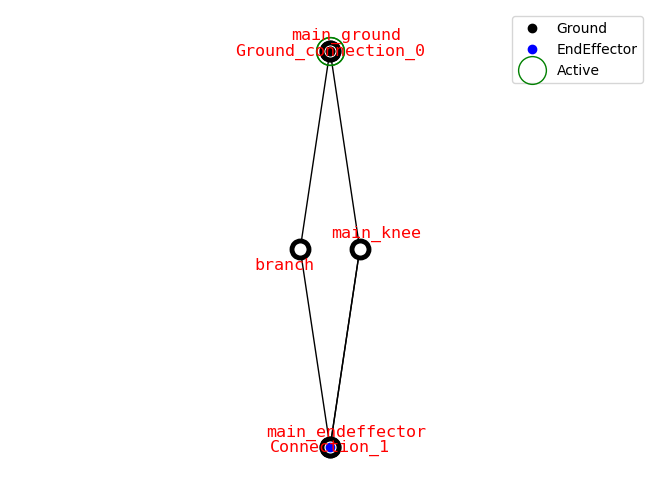

In [6]:
tp = TopologyManager2D()
# creates ground connection
tp.add_connection(ground=True, self_mutation_range= [(-0.2001, 0.1999),None,(-0.1, 0.1)], dependent_mutation_range=[(-0.13,0.07),None,(-0.3,-0.1)])
main_ground_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=True, name='main_ground',attach_ground=True, attach_endeffector=False)
tp.add_absolute_node(jp=main_ground_jp, initial_coordinates=np.array([0, 0, 0]), mutation_range=[None,None,None], freeze_pos=np.array([0,0,0]))
main_knee_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_knee', attach_ground=False, attach_endeffector=False)
tp.add_absolute_node(jp=main_knee_jp, parent_branch_idx=0, initial_coordinates=[0.03, 0, -0.2], mutation_range=[None,None,(-0.1,0.1)], freeze_pos=np.array([0.03,0,None]))
# creates connection on the first link
tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.4,0.4)], dependent_mutation_range=[(-0.1,0.1),None,(-0.1,0.1)])
main_endeffector_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_endeffector',attach_ground=False, attach_endeffector=True)
tp.add_absolute_node(jp=main_endeffector_jp, parent_branch_idx=0, initial_coordinates=np.array([0.0, 0, -0.4]), mutation_range=[None,None,None], freeze_pos=np.array([0.,0,-0.4]))
# creates connection on the second link
tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.5, 0.3)], self_freeze_pos=[0.0,0,-0.4999], dependent_mutation_range=[(-0.2,0.0),None,(-0.0,0.2)])
# creates branch node and one-joint branch in the topology manager. 
branch_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=False, name='branch', attach_ground=False, attach_endeffector=False)
tp.add_relative_node(branch_jp)
# adds a dependent connection of the one-joint branch to the 
tp.add_dependent_connection(0,1,connect_head=True)
# adds independent connection to the second link finishing the branch building
tp.add_independent_connection(tp.branch_ends[1][1],tp.connections[2].connection_jp)
tp.set_mutation_ranges()
tp.mutation_ranges
tp.visualize()

In [7]:
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder)
constrain_error, results = soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)
constrain_error

0.0

In [9]:
pin.seed(1)
topology_index = 0
gm = get_preset_by_index_with_bounds(topology_index)
gm = tp
# activate multiprocessing
N_PROCESS = 4
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

population_size = 64
n_generations = 20

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=actuator)

saver = ProblemSaver(problem, f"first_setup\\topology_{topology_index}", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 2,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

     1 |       64 |     10 |  0.000000E+00 |             f
     2 |      128 |     14 |  0.0383796426 |             f
     3 |      192 |     17 |  0.0547643348 |         ideal
     4 |      256 |     32 |  0.1156186751 |         ideal
     5 |      320 |     40 |  0.0079548909 |             f
     6 |      384 |     45 |  0.0175320196 |         ideal
     7 |      448 |     57 |  0.0790020409 |         ideal
     8 |      512 |     59 |  0.0940478107 |         ideal
     9 |      576 |     64 |  0.0621828467 |         ideal
    10 |      640 |     64 |  0.0258129288 |         ideal
    11 |      704 |     64 |  0.0382181562 |         ideal
    12 |      768 |     64 |  0.0037875940 |             f
    13 |      832 |     64 |  0.1458251569 |         ideal
    14 |      896 |     64 |  0.0031680728 |             f
    15 |      960 |     64 |  0.0322056620 |         ideal
    16 |     1024 |     64 |  0.0305702988 |         ideal
    17 |     1088 |     64 |  0.0056395115 |         ide

In [54]:
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager
def go_to_point(robot, point):

    to_start_from_init = add_auxilary_points_to_trajectory(np.array([point]).T)
    traj_6d = convert_x_y_to_6d_traj_xz(to_start_from_init[0], to_start_from_init[1])
    
    traj_manager = TrajectoryIKManager()
    traj_manager.register_model(robot.model, robot.constraint_models)
    traj_manager.set_solver(traj_manager.default_name)
    pos, q_arrs, __, reach_array = traj_manager.follow_trajectory(traj_6d, np.zeros(robot.model.nq))
    
    result_q = np.zeros(robot.model.nq)
    if reach_array[-1]:
        result_q = q_arrs[-1]
    else:
        raise Exception("Point is not reachable")
    
    return result_q

Scale f1: [-0.25140631447235745, -0.012947170063853264]
Scale f2: [-12.940640154946088, -1.0374561204121506]


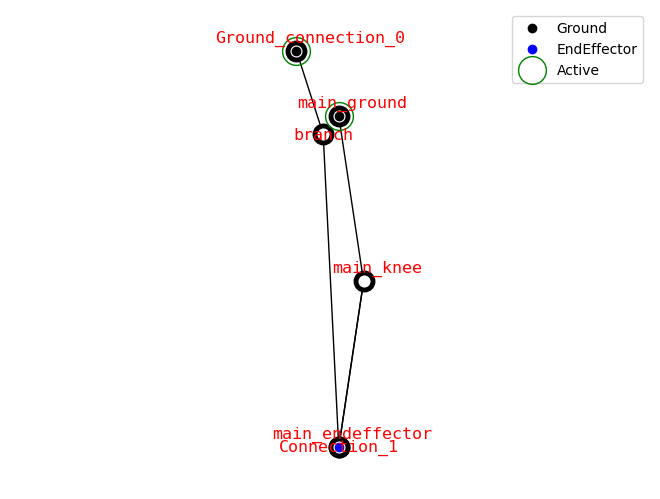

In [34]:
F = res.F
xl, xu = problem.bounds()

fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.3, 0.7])

decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]

graph = gm.get_graph(best_x)
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder=builder)
feature_traj_points = fixed_robot.motion_space.rewind_6d_traj(ground_symmetric_step1[50:,:])[[0, 49, 99]]
draw_joint_point(graph)

d:\work\projects\mechanism_builder\auto_robot_design\simulation\trajectory_movments.py:86: RankWarning: Polyfit may be poorly conditioned
  cs_z_by_x = np.polyfit(self.traj[:,0], self.traj[:,1], 3)


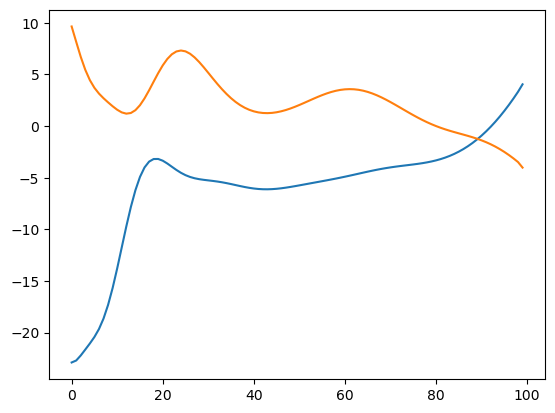

In [56]:
from auto_robot_design.simulation.trajectory_movments import TrajectoryMovements
name_ee = "EE"
point = feature_traj_points[0]
start_q = go_to_point(fixed_robot, point)

test = TrajectoryMovements(feature_traj_points, 1, 0.01, name_ee)
pin.framesForwardKinematics(fixed_robot.model, fixed_robot.data, start_q)

# # q, vq, acc, tau, pos_ee, power
__, __, __, tau_arr, pos_ee, __ = test.simulate(fixed_robot, start_q, False)


# des_traj = np.array(ground_symmetric_step1).T
# plt.plot(pos_ee[:,0], pos_ee[:,2])
# plt.plot(des_traj[:,0], des_traj[:,1], ".")

plt.plot(tau_arr)
plt.show()

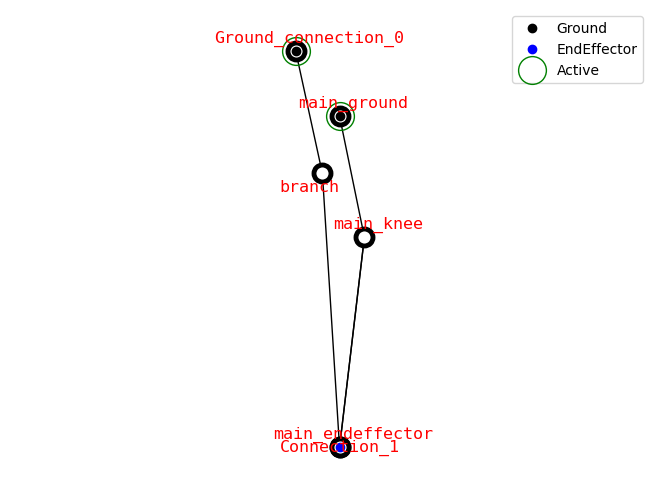

In [17]:
draw_joint_point(graph)

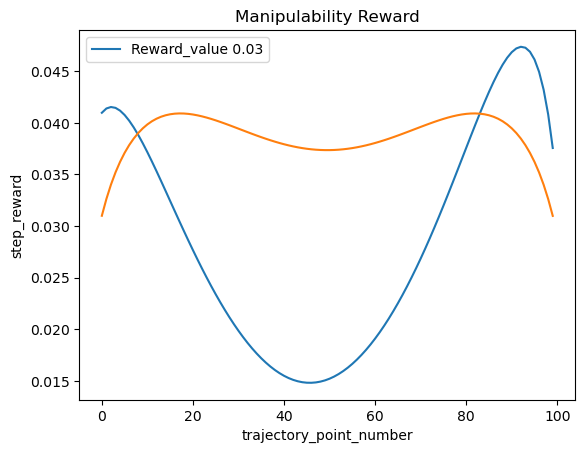

In [35]:
graph = gm.get_graph(best_x)
trajectory = ground_symmetric_step1
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder=builder)
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
reward_class = ManipulabilityReward(manipulability_key='MANIP', trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])

graph_init = tp.get_graph(tp.generate_central_from_mutation_range())
trajectory = ground_symmetric_step1
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph_init, builder=builder)
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
reward_class = ManipulabilityReward(manipulability_key='MANIP', trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)

plt.show()



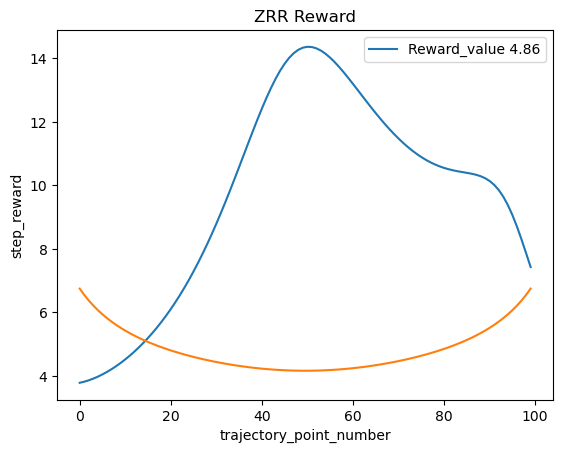

In [36]:
graph = gm.get_graph(best_x)
trajectory = ground_symmetric_step1
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder=builder)
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
reward_class = ZRRReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])

graph_init = tp.get_graph(tp.generate_central_from_mutation_range())
trajectory = ground_symmetric_step1
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph_init, builder=builder)
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
reward_class = ZRRReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

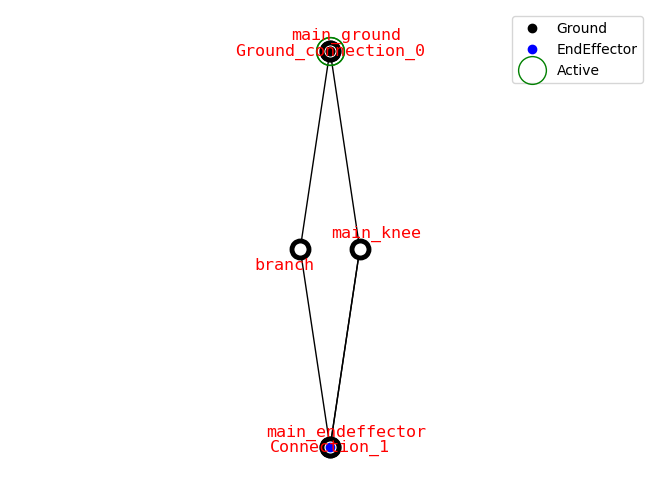

In [13]:
tp.visualize()

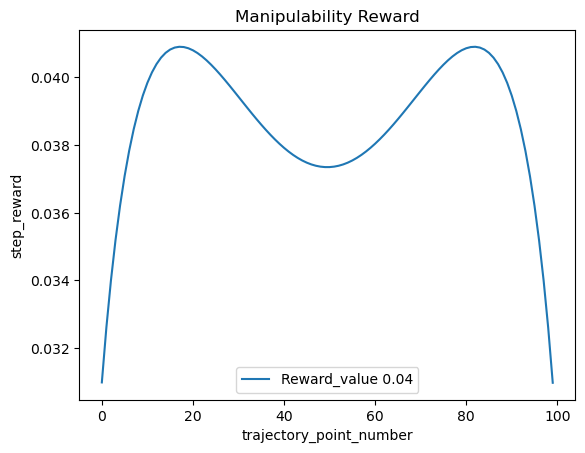

In [14]:

graph_init = tp.graph
trajectory = ground_symmetric_step1
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph_init, builder=builder)
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
reward_class = ManipulabilityReward(manipulability_key='MANIP', trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()